# Импорт библиотек

In [153]:
# Работа с данными
import pandas as pd
import numpy as np

# Построение графиков 
import seaborn as sns
import matplotlib.pyplot as plt

# Построение моделей
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

plt.style.use('fivethirtyeight')

# Загрузка набора данных

In [2]:
df = pd.read_excel('Цены на недвижимость.xlsx')
print(df.shape)
df.head(3)

(34775, 18)


,Цена,Станция метро,Минут до метро,Адрес,Количество комнат,Площадь,Жилая площадь,Кухня площадь,Этаж,Тип сделки,Материал стен,Количество этажей,Лифт,Ремонт,Ссылка,Год постройки,Количество информации в объявлении,Тип квартиры
0,6300000.0,Опалиха,6.0,"Московская область, Красногорский район, Красн...",1.0,30.6,11.1,8.5,25.0,Свободная продажа,Монолитный,25,есть,Косметический,https://www.cian.ru/sale/flat/289238903,NaN,NaN,Вторичное
1,6850000.0,NaN,NaN,"Московская область, Красногорский район, Красн...",1.0,35.6,18.0,7.0,16.0,Свободная продажа,Монолитный,26,есть,Без ремонта,https://www.cian.ru/sale/flat/274781081,NaN,NaN,Вторичное
2,9000000.0,Павшино,2.0,"Московская область, Красногорский район, Красн...",1.0,49.2,20.0,10.0,6.0,Свободная продажа,Кирпичный,15,есть,Евроремонт,https://www.cian.ru/sale/flat/292849723,NaN,NaN,Вторичное


## Удаляем столбцы, которые не будет вводить пользователь

In [3]:
df.drop(['Тип сделки',
         'Материал стен',
         'Лифт',
         'Количество информации в объявлении',
         'Год постройки'], 
         axis = 1, inplace = True)

# Функция для вывода информации о наборе данных

In [4]:
def info_df(df):
    # создаем набор данных
    data = pd.DataFrame()
    # Создаем индексы
    data.index = df.columns
    # Узнаем типы данных
    data['dtypes'] = df.dtypes
    # Количесвто пропущенных значений
    data['isna'] = df.isna().sum()
    # Процент пропущенных значений
    data['isna%'] = round((data['isna'] / df.shape[0])*100, 2)
    
    # Визуализируем количество пропущенных значений в последнем столбце 'isna%'
    return data.style.bar(subset=['isna%'], color='#d65f5f')

# Информация о наборе данных df

In [5]:
info_df(df)

,dtypes,isna,isna%
Цена,float64,133,0.380000
Станция метро,object,11865,34.120000
Минут до метро,float64,11964,34.400000
Адрес,object,41,0.120000
Количество комнат,float64,1887,5.430000
Площадь,float64,0,0.000000
Жилая площадь,float64,9653,27.760000
Кухня площадь,float64,9791,28.160000
Этаж,float64,4062,11.680000
Количество этажей,object,13804,39.700000


### Работа со столбцами 'Цена' и 'Адрес'

In [6]:
df = df[df['Цена'].notna()]
print(df.shape)

df = df[df['Адрес'].notna()]
print(df.shape)

(34642, 13)
(34601, 13)


### Работа со столбцом 'Количество комнат'

In [7]:
"""
В столбце 'Количество комнат' 1887 пропущенных значений - эти значения - студия, раннее мы кодировали студию как значение 0
Поэтому заполним пропущенные значения в столбце 'Количество комнат' - значением 0
"""

df.loc[df['Количество комнат'].isna(), 'Количество комнат'] = \
df.loc[df['Количество комнат'].isna(), 'Количество комнат'].fillna(float(0))

### Работаем со столбцом Адрес

In [8]:
# Заменяем и выделяем регион (москва или московская область)
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('Россия,', ''))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('Московская область', 'Московская'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace(' Московская область', 'Московская'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace(' Москва', 'Москва'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace(' Московская', 'Московская'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('Московская обл', 'Московская'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace(',', ' '))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('гМосква', 'Москва'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('Московская.', 'Московская'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('городМосква', 'Москва'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('Люберецкий', 'Московская'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('Котельники', 'Москва'))
df['Адрес'] = df['Адрес'].apply(lambda x: x.replace('  ', ' '))

In [9]:
# Новый столбец (Регион)
df.insert(3, 'Регион', np.nan)
df['Регион'] = df['Адрес'].apply(lambda x: x.split(' ')[0])
# Оставляем только значения Москвы и области
df = df[(df['Регион'] == 'Московская') | (df['Регион'] == 'Москва')]

# Заменяем вместо Московской на Московскую область
df['Регион'] = df['Регион'].apply(lambda x: x.replace('Московская', 'Московская область'))

### Работа со столбом 'Станция метро' и 'Минут до метро'

In [10]:
# Удаляем слово станция для столбца станция метро
df['Станция метро'] = df[df['Станция метро'].notna()]['Станция метро'].apply(lambda x: str(x).replace('станция ', ''))

In [11]:
# Оставляем только строки, где есть станция метро
df = df[df['Станция метро'].notna()]
df = df[df['Минут до метро'].notna()]

### Работа со столбцами Ремонт

In [12]:
# Уменьшаем количество уникальных значений (без ремонта)
df['Ремонт'] = df[df['Ремонт'].notna()]['Ремонт'].apply(lambda x: str(x).replace('Требует ремонта', 'Без ремонта')\
                                                                          .replace('Отсутствует', 'Без ремонта')\
                                                                          .replace('Под чистовой ремонт', 'Без ремонта')\
                                                                          .replace('no', 'Без ремонта')\
                                                                          .replace('чистовая отделка ', 'Без ремонта')\
                                                                          .replace('Предчистовая отделка', 'Без ремонта')\
                                                                          .replace('Требуется ремонт', 'Без ремонта')\
                                                                          .replace('отделка под чистовую', 'Без ремонта')\
                                                                          .replace('требуется', 'Без ремонта'))

In [13]:
df['Ремонт'] = df[df['Ремонт'].notna()]['Ремонт'].apply(lambda x: str(x).replace('Евро', 'Евроремонт')\
                                                       .replace('косметический', 'Косметический')\
                                                       .replace('евроремонт', 'Евроремонт')\
                                                       .replace('Хороший', 'Евроремонт')\
                                                       .replace('design', 'Дизайнерский')\
                                                       .replace('Авторский проект', 'Дизайнерский')\
                                                       .replace('euro', 'Евроремонт')\
                                                       .replace('cosmetic', 'Косметический')\
                                                       .replace('чистовая отделка', 'Без ремонта')\
                                                       .replace('Типовой', 'Евроремонт')\
                                                       .replace('с ремонтом', 'Евроремонт')\
                                                       .replace('Евро ремонт', 'Евроремонт')\
                                                       .replace('под ключ', 'Евроремонт'))
df['Ремонт'] = df[df['Ремонт'].notna()]['Ремонт'].apply(lambda x: str(x).replace('Евроремонтремонт', 'Евроремонт')\
                                                       .replace('С отделкой', 'Евроремонт')\
                                                       .replace('Частичный ремонт', 'Евроремонт')\
                                                       .replace('Евроремонт ремонт', 'Евроремонт'))

In [57]:
# Набор для заполнения пропущенных значений
repair = df.groupby(['Ремонт']).agg({'Цена': 'mean'})
repair.index.name = None
repair['Цена'] = repair['Цена'].apply(lambda x: '{:.2f}'.format(x))
repair = repair.sort_values(by = 'Цена', ascending = False)
repair

,Цена
Дизайнерский,97365382.88
Без ремонта,71663164.87
Евроремонт,38525704.15
Косметический,17441710.07


In [62]:
df.loc[(df['Цена'] >= 0) & (df['Цена'] < 17441710.07), 'Ремонт'] = \
df.loc[(df['Цена'] >= 0) & (df['Цена'] < 17441710.07), 'Ремонт'].fillna('Косметический')

df.loc[(df['Цена'] >= 17441710.07) & (df['Цена'] < 38525704.15), 'Ремонт'] = \
df.loc[(df['Цена'] >= 17441710.07) & (df['Цена'] < 38525704.15), 'Ремонт'].fillna('Евроремонт')

df.loc[(df['Цена'] >= 38525704.15) & (df['Цена'] < 71663164.87), 'Ремонт'] = \
df.loc[(df['Цена'] >= 38525704.15) & (df['Цена'] < 71663164.87), 'Ремонт'].fillna('Без ремонта')

df.loc[(df['Цена'] >= 71663164.87) & (df['Цена'] < 97365382.88), 'Ремонт'] = \
df.loc[(df['Цена'] >= 71663164.87) & (df['Цена'] < 97365382.88), 'Ремонт'].fillna('Дизайнерский')

df.loc[(df['Цена'] >= 97365382.88), 'Ремонт'] = \
df.loc[(df['Цена'] >= 97365382.88), 'Ремонт'].fillna('Дизайнерский')

### Столбцы 'Жилая площадь' и 'Кухня площадь'

In [88]:
square = df[['Площадь', 'Жилая площадь', 'Кухня площадь']]
square.head(3)

,Площадь,Жилая площадь,Кухня площадь
0,30.6,11.1,8.5
2,49.2,20.0,10.0
3,44.7,16.2,13.1


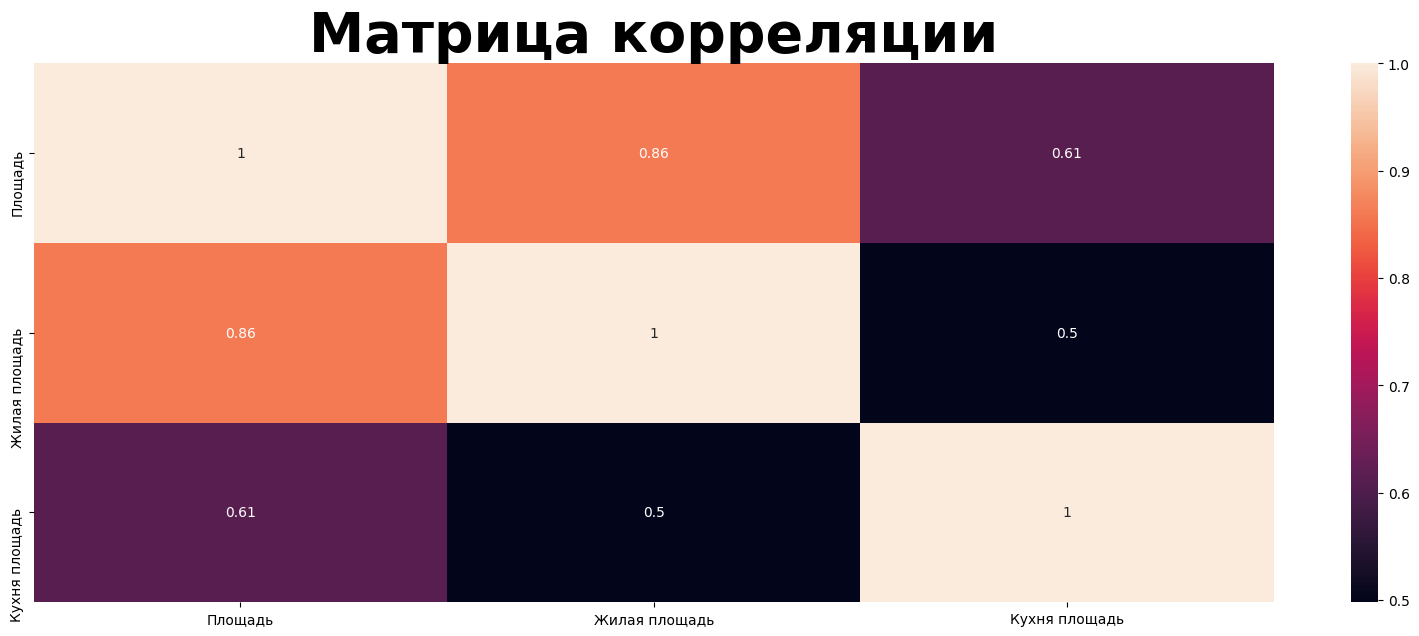

In [89]:
plt.subplots(figsize = (20,7))
correlation = round(square.corr(),3)
sns.heatmap(correlation, annot = True)
plt.title('Матрица корреляции', fontsize = 40, fontweight = 'bold')
plt.show()

    Что бы заполнить признаки Жилая площадь будем использовать модель Линейной регресии
    Сосатвим 2 набора данных - обучающий (обучим модель)
                             - тестовый (заполим значения nan)

# Заполнение Жилая площадь с помощью LinearRegression

In [121]:
# Набор данных для парной линейной регрессии
fill_lr = square.drop('Кухня площадь', axis = 1)

# Тестовый (для заполнения)
test = fill_lr[fill_lr['Жилая площадь'].isna()]

# Тренировочный (для трениовки)
train = fill_lr[fill_lr['Жилая площадь'].notna()]

In [122]:
X = train['Площадь']
y = train['Жилая площадь']

# Для sklearn LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

In [123]:
# Построим модель линейной регрессии через statsmodel.api

X = sm.add_constant(X)
model = sm.OLS(y, X)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Жилая площадь   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                 4.323e+04
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:50:54   Log-Likelihood:                -67570.
No. Observations:               15389   AIC:                         1.351e+05
Df Residuals:                   15387   BIC:                         1.352e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1347      0.234      9.122      0.0

In [124]:
print(res.params)

const      2.134668
Площадь    0.505550
dtype: float64


    Коэффициент детерминации (R-squared) - равен 0.738, то есть данная формула объясняет 73% дисперсии
    Коэффициенты - intercept = 2.1347, то есть при нулевой площади значений жилой площадт будет равно 2.1347
                   Площадь - 0.5055 - то есть жилая площадь равна половине общей площади квартиры
                   
    Построим модель линейной регрессии, визуализируем результаты предсказания

### Оценка модели линейной регрессии + построение sklearn LinearRegression

In [135]:
# Добавляем столбец с константой (1)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Обозначаем модель линейной регрессии
lr = LinearRegression()

# Тренируем модель линейной регрессии
lr.fit(X_train, y_train)

LinearRegression()

In [139]:
# Получаем коэффициенты регрессии (веса) и свободный член (intercept)
coefficients = lr.coef_
intercept = lr.intercept_

print("Коэффициенты регрессии:", coefficients)
print("Свободный член (intercept):", intercept)

Коэффициенты регрессии: [0.         0.49286839]
Свободный член (intercept): 2.900895587041447


    Коэффициенты регрессии и intercept практически совпадают с той моделью, которую мы построили с помощью statsmodel.api
    Различия могут быть из за того, что предыдущую модель мы обучали на полном наборе данных, а здесь, для того, чтобы проверить метрики (и визуализировать результаты предсказания) мы использовали только 70% данных
    Далее после оценки, мы дотренируем модель в sklearn на полном наборе данных и заменим NaN в основном наборе данных

In [147]:
train_pred = lr.predict(X_test)

# Метрики для проверки качества модели
mae = mean_absolute_error(y_test, train_pred)
mape = mean_absolute_percentage_error(y_test, train_pred)

print('MAE: ', mae)
print('MAPE: ', round(mape * 100,2))

MAE:  9.596477867499145
MAPE:  34.67


    Отклонение от фактического значения - 9, то есть в среднем предсказаное значение от фактического отличается на 9 (MAE)
    В среднем значение отклоняется на 34% (MAPE)

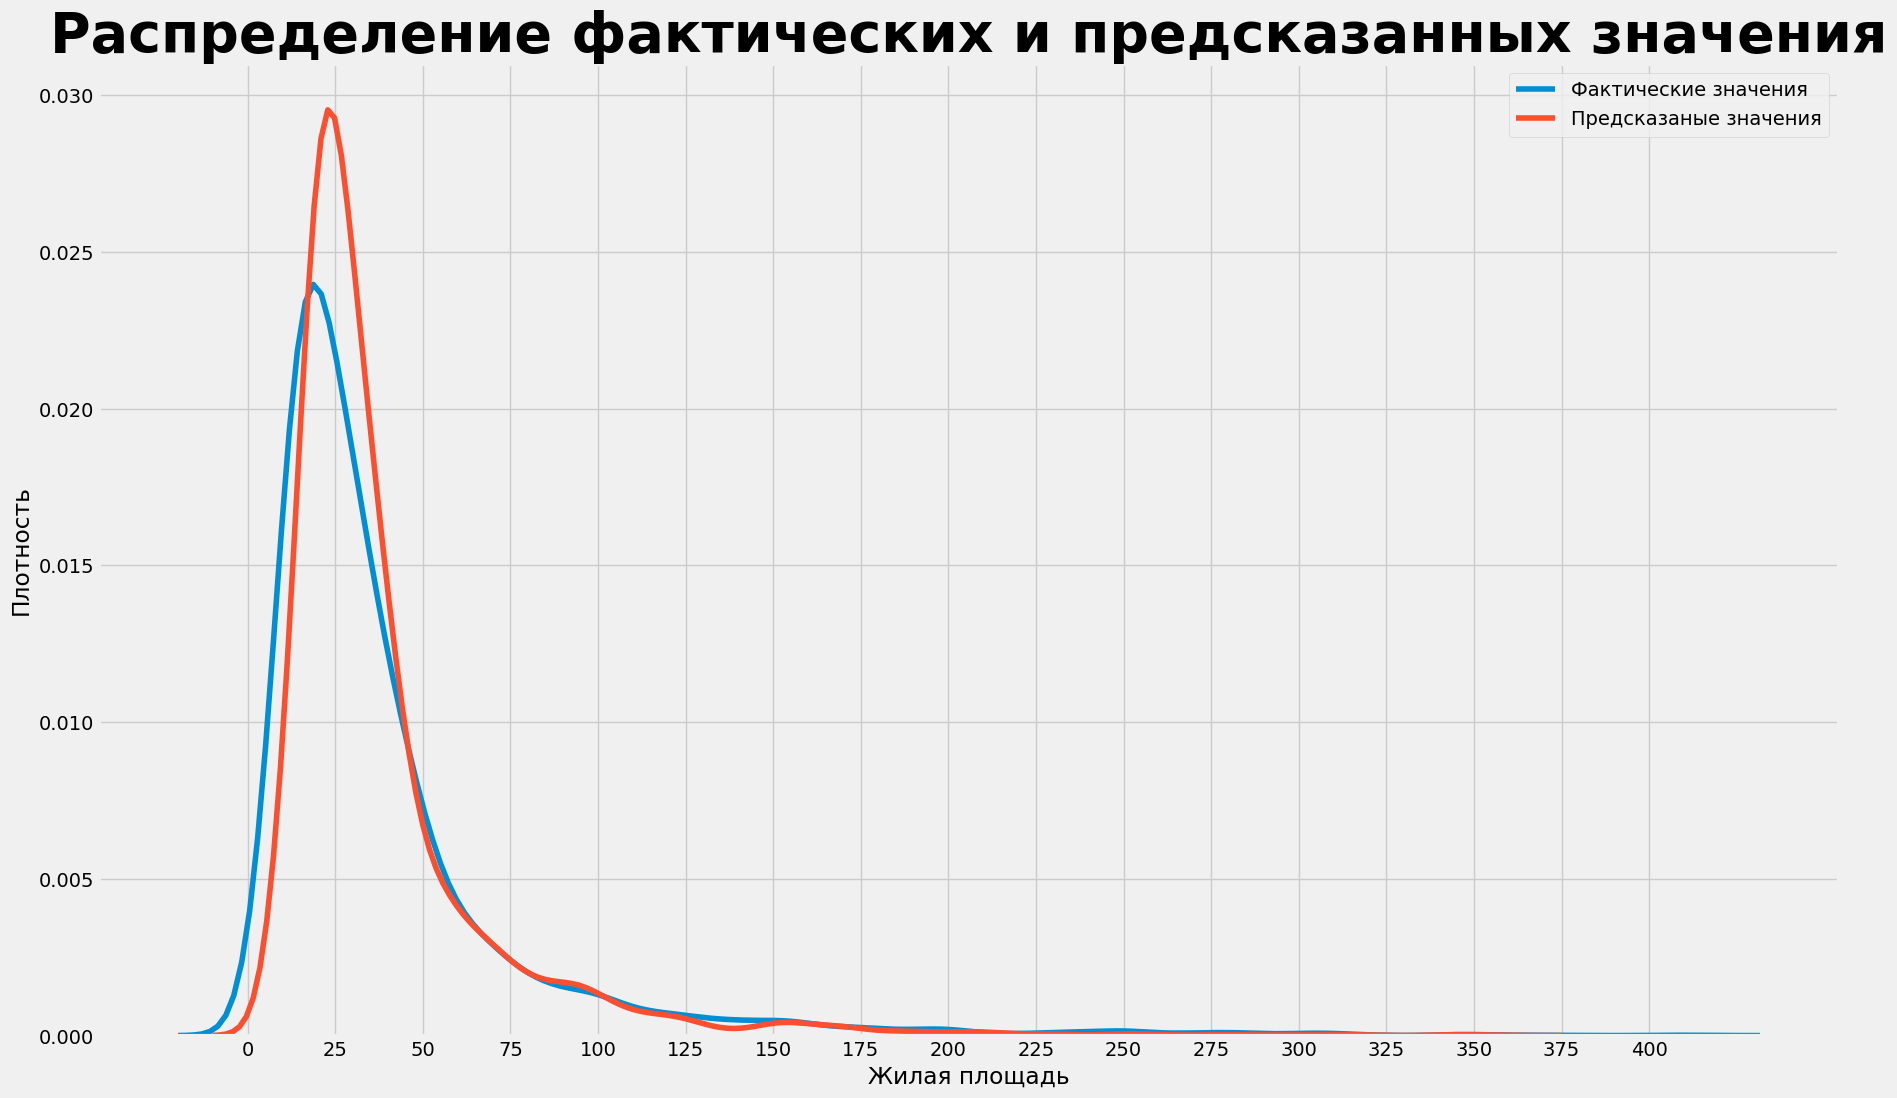

In [163]:
plt.subplots(figsize = (20,12))

sns.kdeplot(y_test, label='Фактические значения')
sns.kdeplot(train_pred, label='Предсказаные значения')

plt.title('Распределение фактических и предсказанных значения', fontsize = 40, fontweight = 'bold')
plt.ylabel('Плотность')
plt.legend()
plt.xticks(range(0,401,25))
plt.show()

    Модель линейной регрессии больше смещена вправо 
    То есть как видно по диаграмме у фактических значений высокая плотность вероятности в диапазоне от 0 до 50 
    А высокая плотность вероятности у предсказаных значений в диапазоне от 15 до 75
    Следовательно значения больше смещены вправо
    
    Так же стоит заметить что тут логнормальное распределение (следовательно можно логарифмировать данные, чтобы привести их ближе к нормальному виду)
    Эту операцию уже будем делать с основным набором данных
    
    Далее натренируем модель на полном наборе данных и заполним пропуски используя натренированную модель линейной регрессии

### Дотренировываем модель на полном наборе данных

### Заполняем пропуски в столбце Жилая площадь